In [1]:
# load libraries
import os, glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

2024-07-06 21:27:35.584765: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 21:27:35.584978: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 21:27:35.588032: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 21:27:35.622595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-06 21:27:36.269655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Create training and validating dataset

In [2]:
seed = 42
n_X = 60
n_y = 1
step = 1 
sequence_length = int(n_X/step)

batch_size = 128

In [3]:
# load data
data_running = pd.read_csv("./datasets/processed/running.csv", index_col="timestamp")
data_biking = pd.read_csv("./datasets/processed/biking.csv", index_col="timestamp")

data_running.index = pd.to_datetime(data_running.index)
data_biking.index = pd.to_datetime(data_biking.index)

In [4]:
data_biking

,heart-rate,speed,cadence,distance
timestamp,,,,
2020-08-18 14:43:19,102.0,4.3250,64.0,0.0000
2020-08-18 14:43:20,103.0,4.3360,64.0,4.3360
2020-08-18 14:43:21,105.0,4.4090,66.0,8.7450
2020-08-18 14:43:22,106.0,4.4450,66.0,13.1900
2020-08-18 14:43:23,106.0,4.4410,67.0,17.6310
...,...,...,...,...
2020-09-13 14:55:56,130.0,1.6245,52.0,73317.6675
2020-09-13 14:55:57,130.0,1.6245,52.0,73319.2920
2020-09-13 14:55:58,130.0,1.6245,52.0,73320.9165


In [5]:
# calculate the data normalisation parameters from all training data
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    # return (data - data_mean) / data_std, data_mean, data_std
    return data_mean, data_std


def denormalize_hr(data, df_mean, df_std):
    return data * df_std.iloc[0] + df_mean.iloc[0]

In [6]:
# iterrate through each date and print the data of the day
dates = data_running.groupby(data_running.index.date).groups.keys()
# Split the data into training and validation
# We will use the last 0.25 of the date for validation
# The rest is for training
def split_data(data, split_date):
    return data[data.index.date < split_date], data[data.index.date >= split_date]

# split the data
split_date = list(dates)[-int(0.25*len(dates))]
train_df_running, val_df_running = split_data(data_running, split_date)
dates = data_biking.groupby(data_biking.index.date).groups.keys()
split_date = list(dates)[-int(0.25*len(dates))]
train_df_biking, val_df_biking = split_data(data_biking, split_date)

In [7]:
dates

dict_keys([datetime.date(2020, 8, 18), datetime.date(2020, 8, 20), datetime.date(2020, 8, 26), datetime.date(2020, 9, 13)])

In [8]:
def process_data(data):

    n = 0
    for date in tqdm(data.groupby(data.index.date)):
        df = date[1]

        start = n_X + n_y
        end = n_X + len(df.index)

        x = df.values
        y = df.iloc[start:end][["heart-rate"]]

        dataset = keras.preprocessing.timeseries_dataset_from_array(
            x,
            y,
            sequence_length=sequence_length,
            sampling_rate=step,
            batch_size=batch_size,
        )
        if n == 0:
            res = dataset
        else:
            res = res.concatenate(dataset)

        n += 1
    return res


# Create time series data
def create_time_series(train, val):
    mean, std = normalize(train)
    train = (train - mean) / std
    val = (val - mean) / std

    train = process_data(train)
    val = process_data(val)

    return train, val, mean, std

In [9]:
train_running, val_running, mean_running, std_running = create_time_series(train_df_running, val_df_running)
train_biking, val_biking, mean_biking, std_biking = create_time_series(train_df_biking, val_df_biking)

100%|██████████| 1/1 [00:00<00:00, 27.87it/s]


## Model

In [10]:
def create_model(input, lr):
    inputs = keras.layers.Input(shape=(input.shape[1], input.shape[2]))
    x = keras.layers.LSTM(64, return_sequences=True)(inputs)
    x = keras.layers.LSTM(64)(x)
    x = keras.layers.Dropout(0.2)(x)
    output = keras.layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=output, name="hr_model")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=["mae"],
        loss="mae",
    )
    return model

In [11]:
# learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=50000, decay_rate=0.001
)

path_checkpoint = "model_checkpoint.keras"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_mae", min_delta=0, patience=5, verbose=1
)


modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_mae",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
)


### Running

In [12]:
# get the shapes of X & y for a batch
for batch in train_running.take(1):
    inputs, targets = batch

model = create_model(inputs, lr_schedule)
model.summary()

2024-07-06 21:27:39.501267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "hr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,753 (198.25 KB)

 Trainable params: 50,753 (198.25 KB)

 Non-trainable params: 0 (0.00 B)

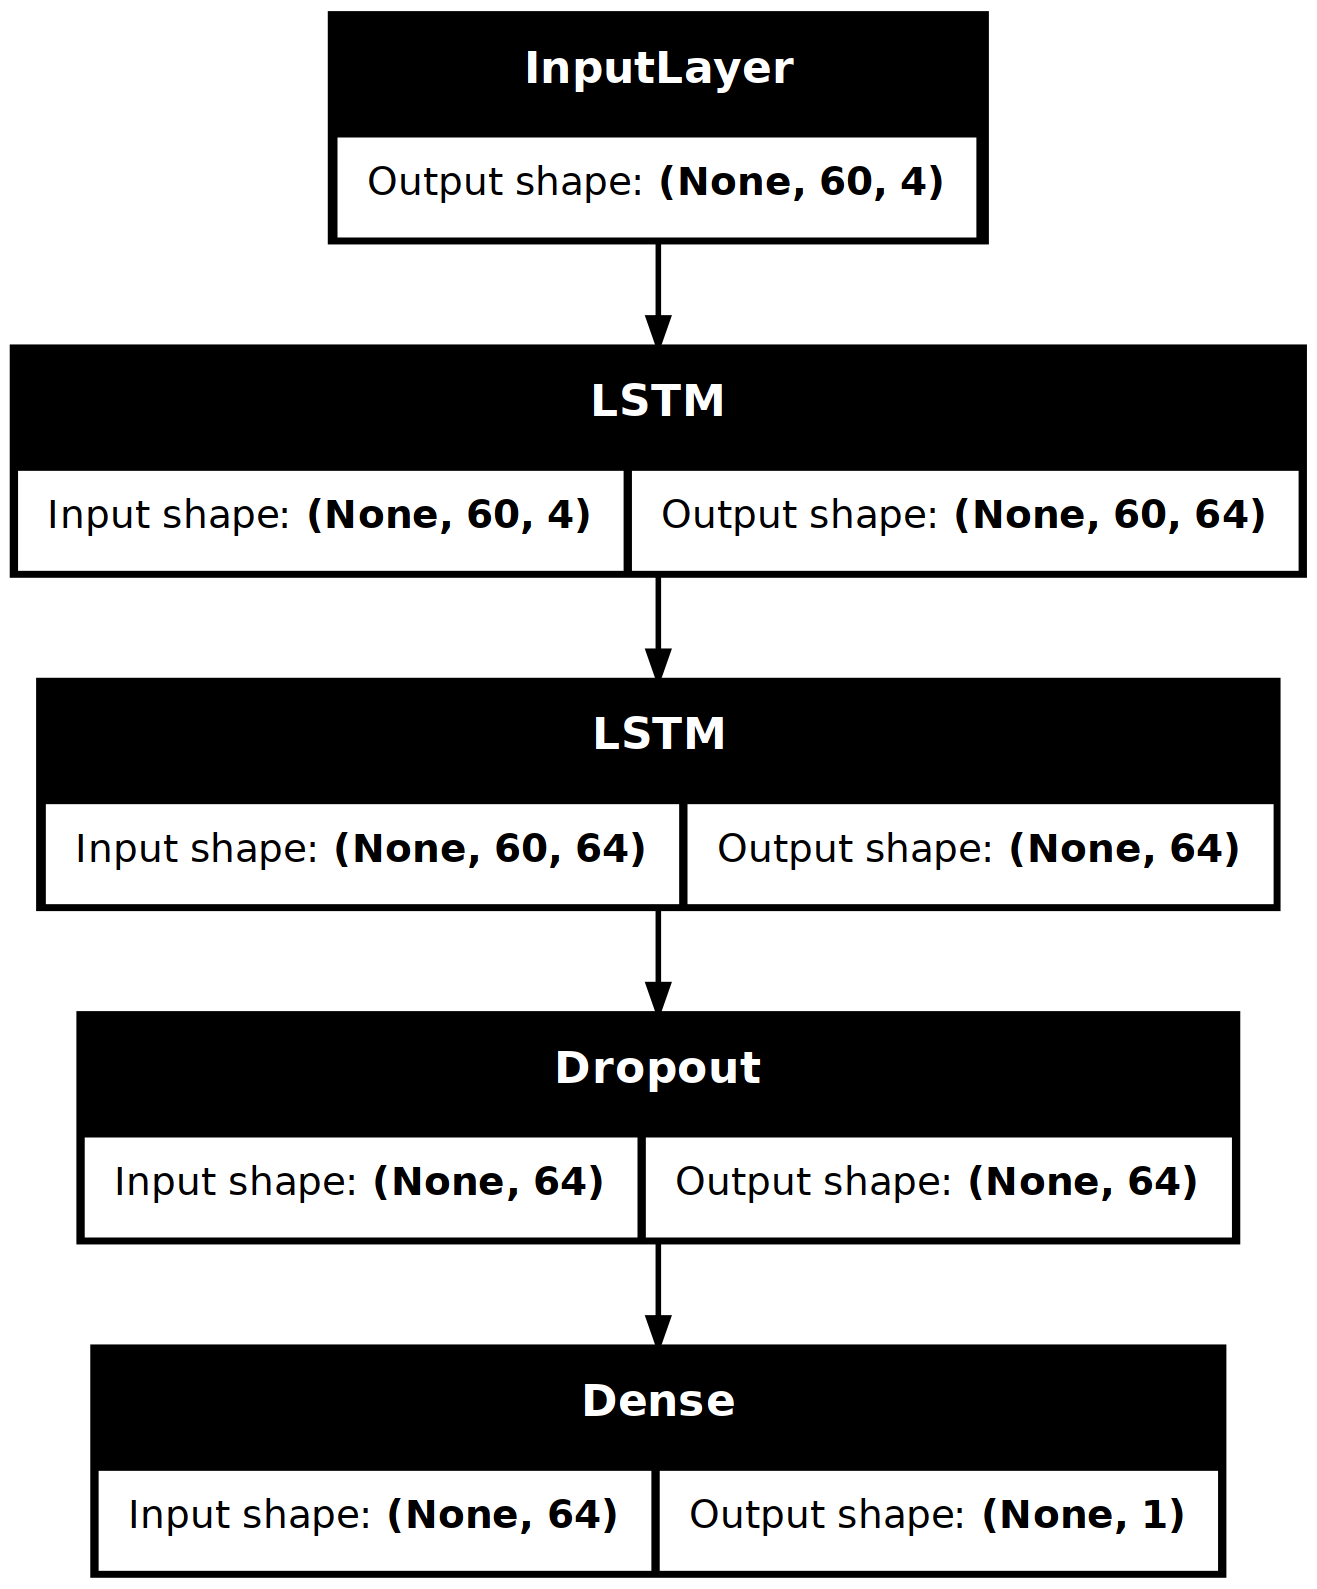

In [14]:
# Draw a plot of the model
keras.utils.plot_model(model, show_shapes=True)

In [13]:
# train the model
history = model.fit(
    train_running,
    epochs=20,
    validation_data=val_running,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3754 - mae: 0.3754
Epoch 1: val_mae improved from inf to 0.24459, saving model to model_checkpoint.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.3745 - mae: 0.3745 - val_loss: 0.2446 - val_mae: 0.2446
Epoch 2/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1685 - mae: 0.1685
Epoch 2: val_mae improved from 0.24459 to 0.11762, saving model to model_checkpoint.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.1684 - mae: 0.1684 - val_loss: 0.1176 - val_mae: 0.1176
Epoch 3/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1321 - mae: 0.1321
Epoch 3: val_mae did not improve from 0.11762
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.1321 - mae: 0.1321 - val_loss: 0.1201 - val_mae: 0.1201
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1136 - mae: 0.1136
Epoch 4: val_mae improved from 0.11762 to 0.09263, saving model to model_checkpoint.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 

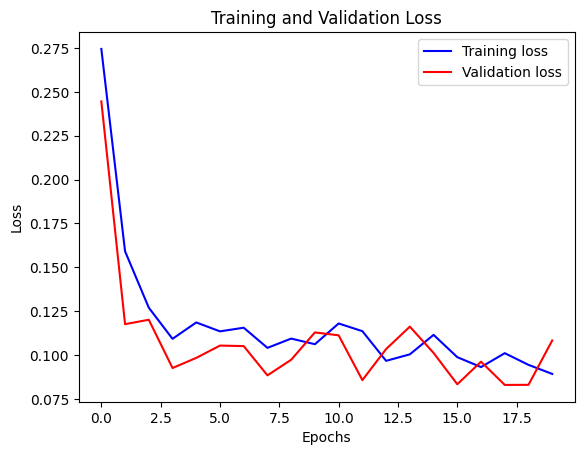

In [14]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

visualize_loss(history, "Training and Validation Loss")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


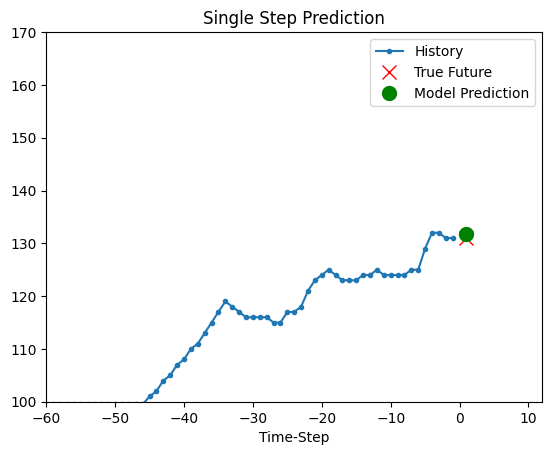

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


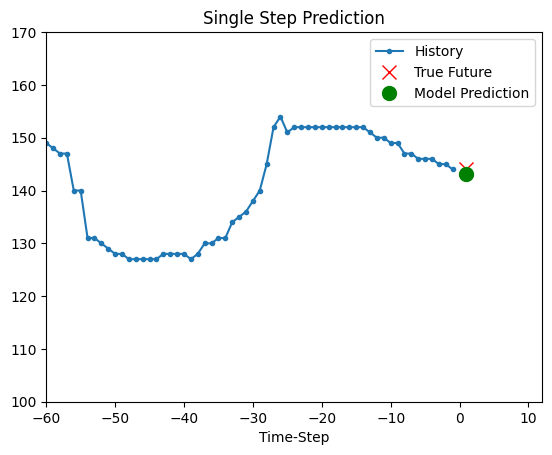

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


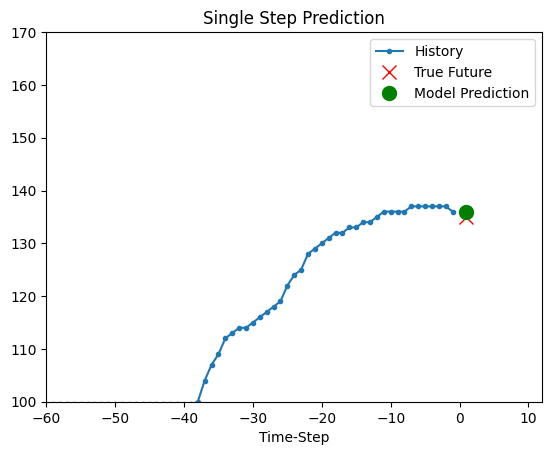

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


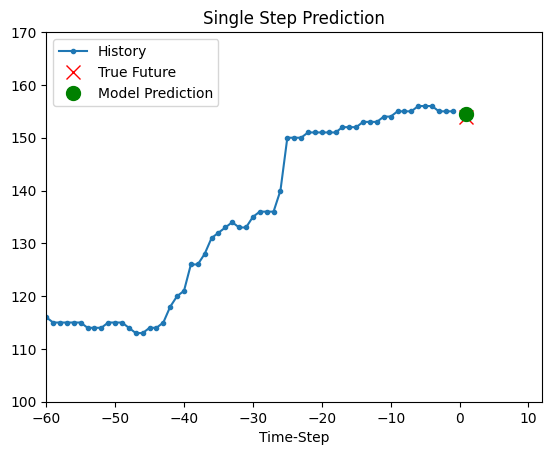

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


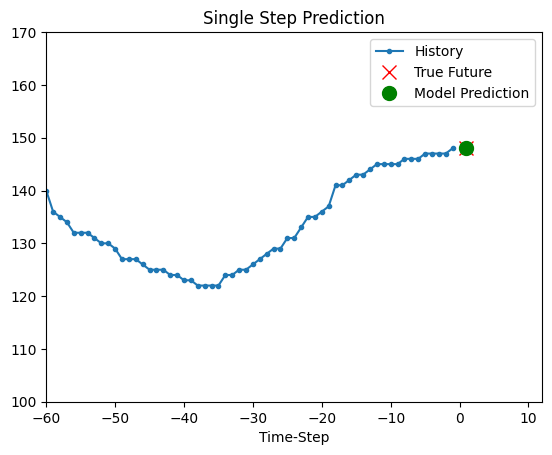

2024-07-06 21:12:52.983853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.ylim(100, 170)
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in val_running.take(5):
    show_plot(
        [
            denormalize_hr(x[0][:, 0].numpy(), mean_running, std_running),
            denormalize_hr(y[0], mean_running, std_running),
            denormalize_hr(model.predict(x)[0], mean_running, std_running),
        ],
        n_y,
        "Single Step Prediction",
    )

### Biking

In [16]:
# get the shapes of X & y for a batch
for batch in train_biking.take(1):
    inputs, targets = batch

model = create_model(inputs, lr_schedule)
model.summary()

2024-07-06 21:12:53.029210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "hr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,753 (198.25 KB)

 Trainable params: 50,753 (198.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# train the model
history = model.fit(
    train_biking,
    epochs=20,
    validation_data=val_biking,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
237/238 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3286 - mae: 0.3286
Epoch 1: val_mae improved from 0.08300 to 0.07659, saving model to model_checkpoint.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.3277 - mae: 0.3277 - val_loss: 0.0766 - val_mae: 0.0766
Epoch 2/20
237/238 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1318 - mae: 0.1318
Epoch 2: val_mae did not improve from 0.07659
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.1317 - mae: 0.1317 - val_loss: 0.2365 - val_mae: 0.2365
Epoch 3/20
237/238 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1018 - mae: 0.1018
Epoch 3: val_mae did not improve from 0.07659
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.1017 - mae: 0.1017 - val_loss: 0.0974 - val_mae: 0.0974
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1082 - mae: 0.1082
Epoch 4: val_mae did not improve from 0.07659
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.1084 - mae: 0.1084 - val_loss: 0.2340 - val_mae: 0.2340
Epoch 5/20


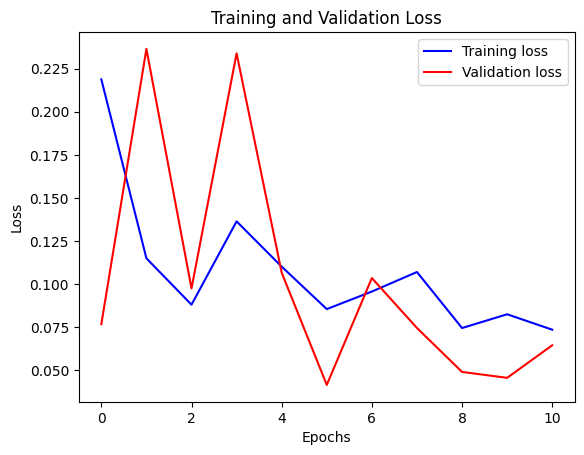

In [18]:
visualize_loss(history, "Training and Validation Loss")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


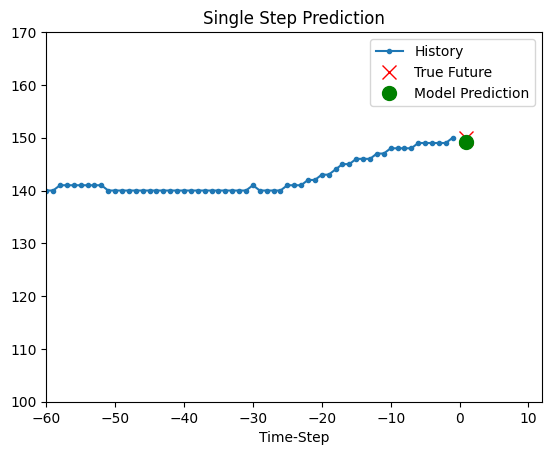

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


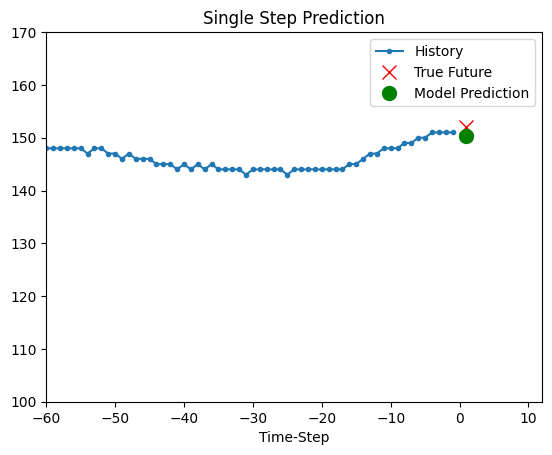

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


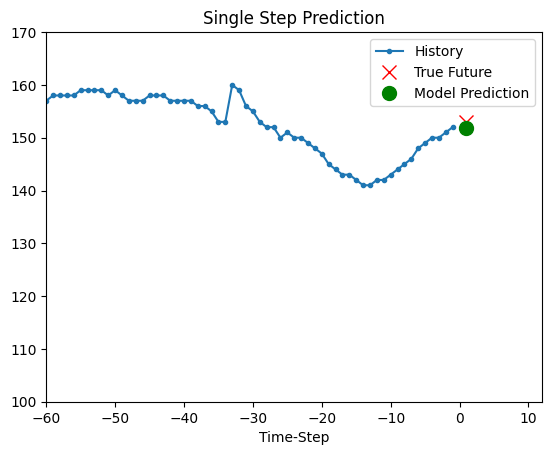

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


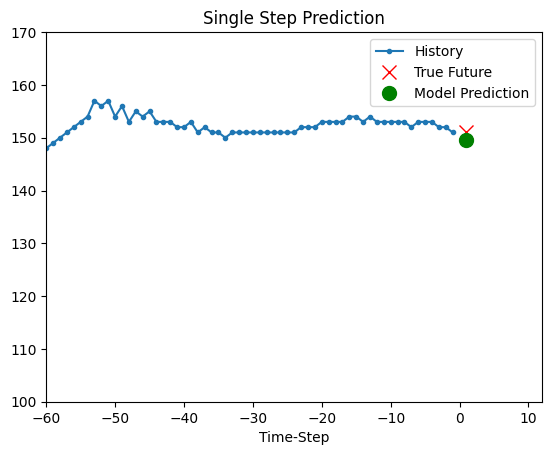

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


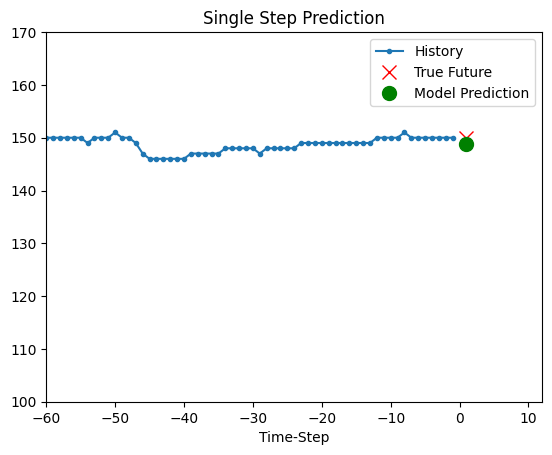

2024-07-06 21:14:39.240642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
for x, y in val_biking.take(5):
    show_plot(
        [
            denormalize_hr(x[0][:, 0].numpy(), mean_biking, std_biking),
            denormalize_hr(y[0], mean_biking, std_biking),
            denormalize_hr(model.predict(x)[0], mean_biking, std_biking),
        ],
        n_y,
        "Single Step Prediction",
    )

### Using both running and biking

In [20]:
# Merge the 2 training datasets
train = train_running.concatenate(train_biking)
val = val_running.concatenate(val_biking)

# get the shapes of X & y for a batch
for batch in train.take(1):
    inputs, targets = batch

model = create_model(inputs, lr_schedule)
model.summary()

2024-07-06 21:14:47.790133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "hr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,753 (198.25 KB)

 Trainable params: 50,753 (198.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# train the model
history = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
451/452 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2575 - mae: 0.2575
Epoch 1: val_mae did not improve from 0.04129
452/452 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - loss: 0.2572 - mae: 0.2572 - val_loss: 0.1862 - val_mae: 0.1862
Epoch 2/20
451/452 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1123 - mae: 0.1123
Epoch 2: val_mae did not improve from 0.04129
452/452 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - loss: 0.1123 - mae: 0.1123 - val_loss: 0.0886 - val_mae: 0.0886
Epoch 3/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1202 - mae: 0.1202
Epoch 3: val_mae did not improve from 0.04129
452/452 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.1202 - mae: 0.1202 - val_loss: 0.0962 - val_mae: 0.0962
Epoch 4/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1101 - mae: 0.1101
Epoch 4: val_mae did not improve from 0.04129
452/452 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - loss: 0.1101 - mae: 0.1101 - val_loss: 0.2214 - val_mae: 0.2214
Epoch 5/20
451/452 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

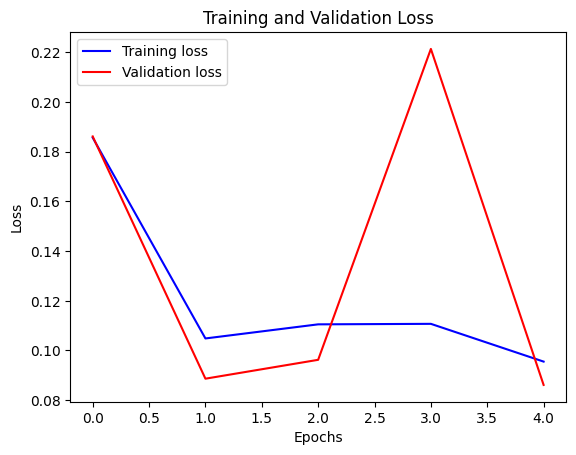

In [25]:
visualize_loss(history, "Training and Validation Loss")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


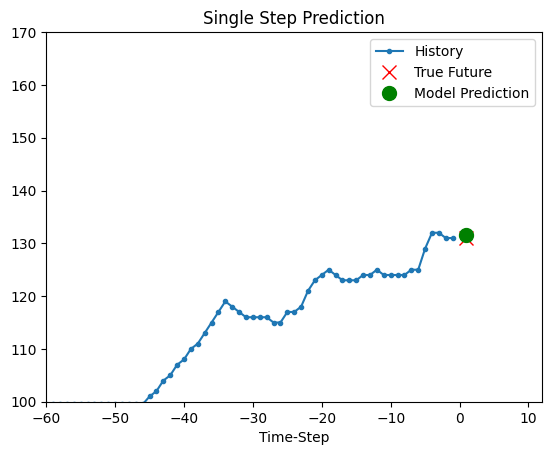

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


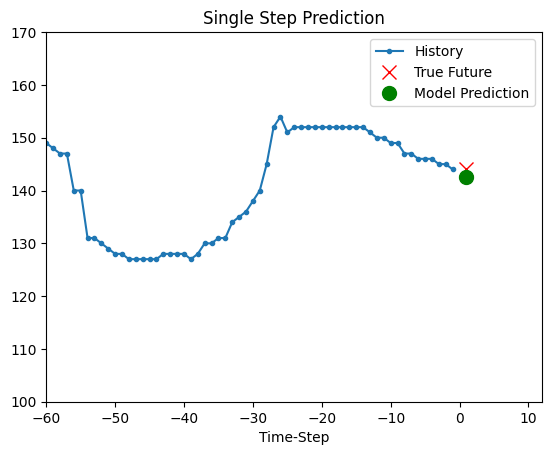

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


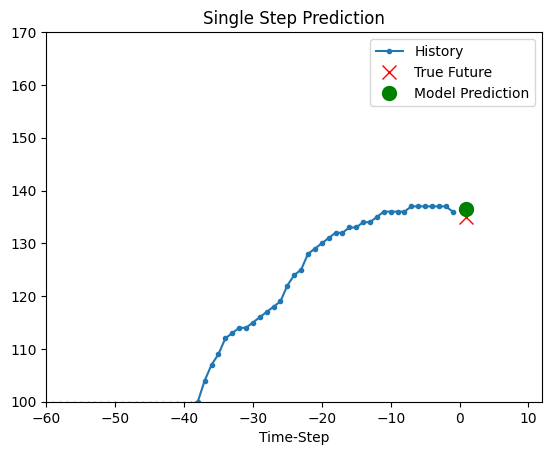

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


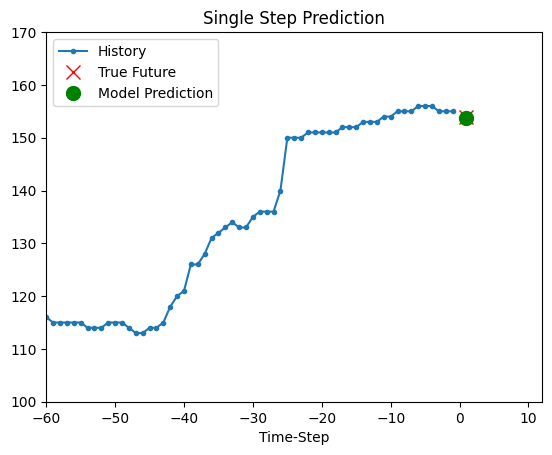

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


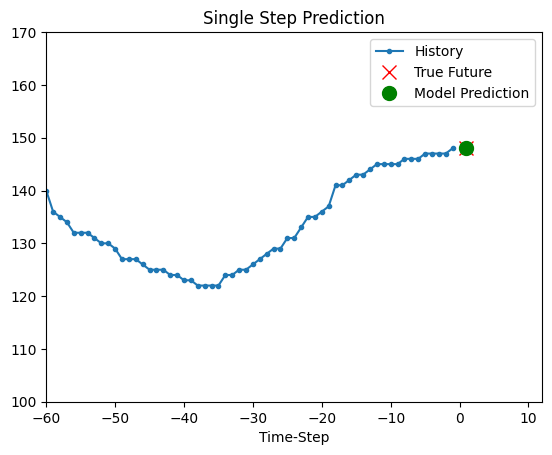

2024-07-06 21:16:46.675716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Evaluate on the original validation running data
for x, y in val_running.take(5):
    show_plot(
        [
            denormalize_hr(x[0][:, 0].numpy(), mean_running, std_running),
            denormalize_hr(y[0], mean_running, std_running),
            denormalize_hr(model.predict(x)[0], mean_running, std_running),
        ],
        n_y,
        "Single Step Prediction",
    )

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


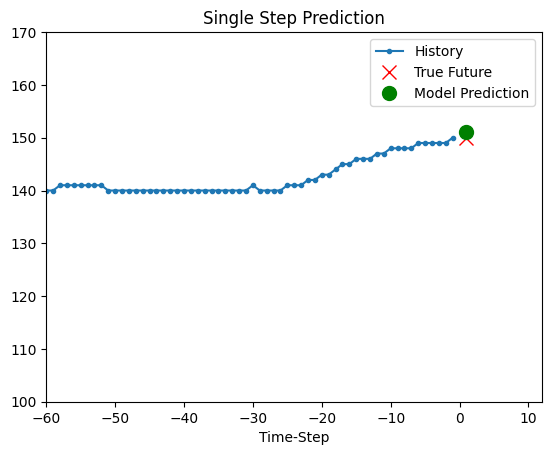

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


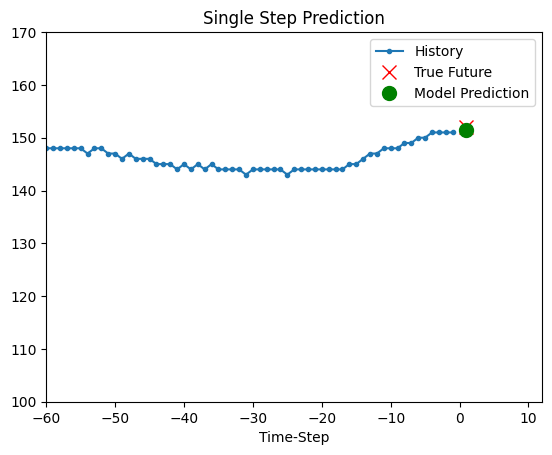

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


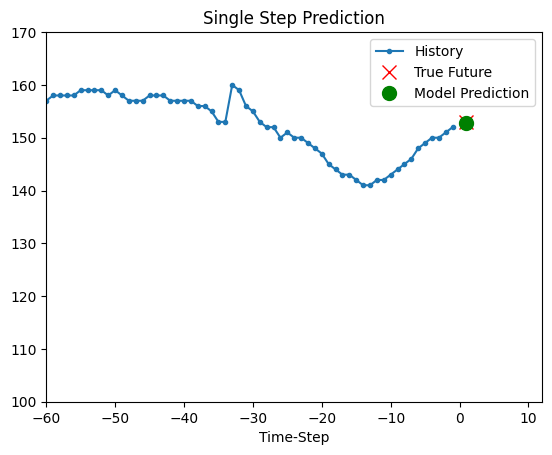

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


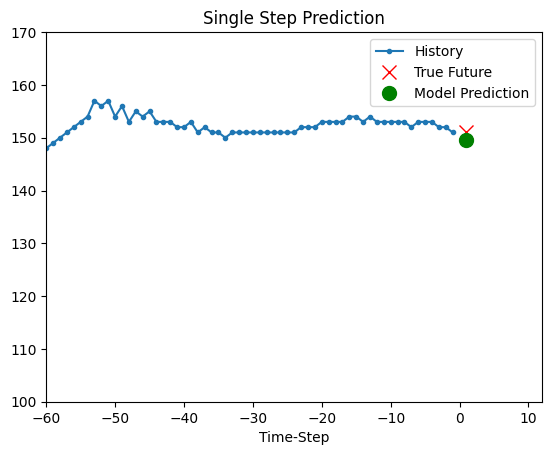

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


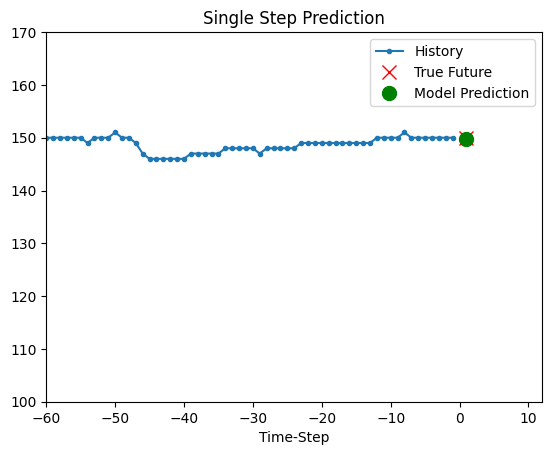

2024-07-06 21:16:47.368296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
# Evaluate on the original validation biking data
for x, y in val_biking.take(5):
    show_plot(
        [
            denormalize_hr(x[0][:, 0].numpy(), mean_biking, std_biking),
            denormalize_hr(y[0], mean_biking, std_biking),
            denormalize_hr(model.predict(x)[0], mean_biking, std_biking),
        ],
        n_y,
        "Single Step Prediction",
    )